Dictionary learning to extract brain networks and regions within them. 

Inspired from nilearn documentation

In [ ]:
pip install nilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from nilearn import image
from nilearn import plotting

In [ ]:
from nilearn import datasets
num = 40
adhd_data = datasets.fetch_adhd(n_subjects=num) #reads the fMRI dataset

In [ ]:
np.shape(adhd_data.func[:15])

In [ ]:
#splits the data into subjects that have vs don't have ADHD, as per the labels
#provided

here = np.where(adhd_data.phenotypic['adhd'] == 1)[0]

adhd_data_func_yes = []
adhd_data_func_no = []
adhd_data_conf_yes = []
adhd_data_conf_no = []

for i in range(40):
  if i in here:
    adhd_data_func_yes.append(adhd_data.func[i])
    adhd_data_conf_yes.append(adhd_data.confounds[i])
  else:
    adhd_data_func_no.append(adhd_data.func[i])
    adhd_data_conf_no.append(adhd_data.confounds[i])

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()
/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_axes.py:73: UserWarning: No contour levels were found within the data range.
  **kwargs)
/usr/local/lib/python3.7/dist-packages/nilearn/plotting/displays/_axes.py:73: UserWarning: linewidths is ignored by contourf
  **kwargs)


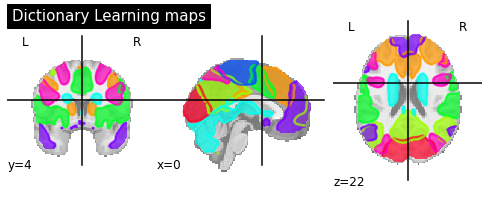

In [ ]:
#fits dictionary learning clustering method to the data to extract functional
#networks

from nilearn.decomposition import DictLearning

# Initialize DictLearning object
dict_learn = DictLearning(n_components=8, smoothing_fwhm=6.,
                          memory="nilearn_cache", memory_level=2,
                          random_state=0)
# Fit to the data
dict_learn.fit(adhd_data.func)
# Resting state networks/maps in attribute `components_img_`
components_img = dict_learn.components_img_

# Visualization of functional networks
from nilearn import plotting

plotting.plot_prob_atlas(components_img, view_type='filled_contours',
                         title='Dictionary Learning maps')

In [ ]:
np.shape(components_img)

(61, 73, 61, 8)

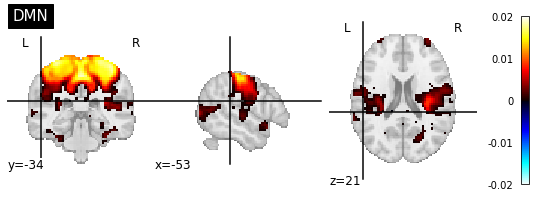

In [ ]:
plotting.plot_stat_map(image.index_img(components_img, 5), title='DMN', cut_coords = (-53, -34, 21))
plotting.show()

In [ ]:
#extracts regions from within the functional networks we identified

from nilearn.regions import RegionExtractor

extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=1350)
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

# Visualization of region extraction results
title = ('%d regions are extracted from %d components.'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted, 8))
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)

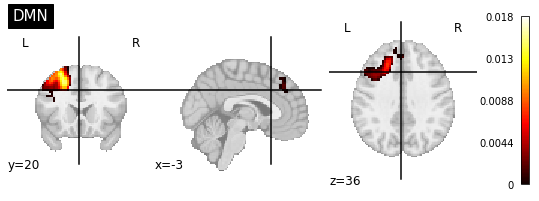

In [ ]:
plotting.plot_stat_map(image.index_img(regions_extracted_img, 16), title='DMN', cut_coords = (-3, 20, 36))
plotting.show()

In [ ]:
#Measuring connectivity (correlation) between the regions we extracted

from nilearn.connectome import ConnectivityMeasure

correlations = []
# Initializing ConnectivityMeasure object with kind='correlation'
connectome_measure = ConnectivityMeasure(kind='correlation')
for filename, confound in zip(adhd_data.func, adhd_data.confounds):
    # call transform from RegionExtractor object to extract timeseries signals
    timeseries_each_subject = extractor.transform(filename, confounds=confound)
    # call fit_transform from ConnectivityMeasure object
    correlation = connectome_measure.fit_transform([timeseries_each_subject])
    # saving each subject correlation to correlations
    correlations.append(correlation)

# Mean of all correlations
import numpy as np
mean_correlations = np.mean(correlations, axis=0).reshape(n_regions_extracted,
                                                          n_regions_extracted)

In [ ]:
#creating a connectivity matrix of just the default-mode network regions

np.shape(correlations)

corrs = np.array(correlations)

corrs = corrs.reshape(40, n_regions_extracted, n_regions_extracted)

DMN_conn = corrs[np.ix_(list(range(40)), here, here)]

np.shape(DMN_conn)

(40, 5, 5)

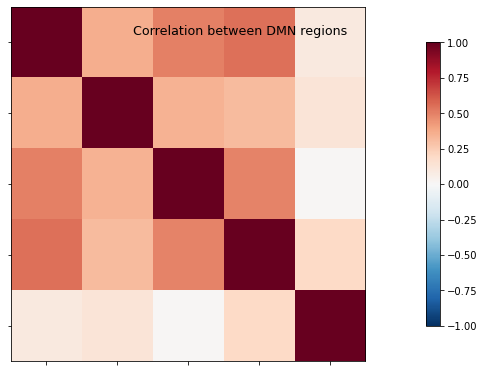

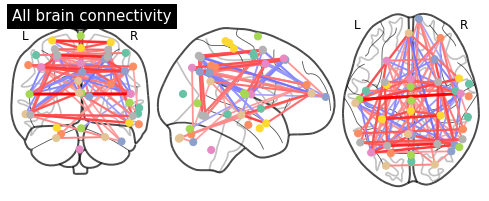

In [ ]:
#plots the correlation matrix and lines to represent connectivity on a brain 
#mesh

title = 'Correlation between DMN regions' 
title2 = 'All brain connectivity' 


# First plot the matrix
display = plotting.plot_matrix(out, vmax=1, vmin=-1,
                               colorbar=True, title=title)

# Then find the center of the regions and plot a connectome
regions_img = regions_extracted_img
coords_connectome = plotting.find_probabilistic_atlas_cut_coords(regions_img)

plotting.plot_connectome(mean_correlations, coords_connectome,
                         edge_threshold='90%', title=title2)

K-means clustering to cluster brain networks

Inspired from nilearn documentation

In [ ]:
#initializes the k-means object and fit it to the fMRI data
from nilearn.regions import Parcellations
import time

start = time.time()
kmeans = Parcellations(method='kmeans', n_parcels=20,
                       standardize=True, smoothing_fwhm=10.,
                       memory='nilearn_cache', memory_level=1,
                       verbose=1)
# Call fit on functional dataset
kmeans.fit(adhd_data.func)
print("KMeans clusters: %.2fs" % (time.time() - start))

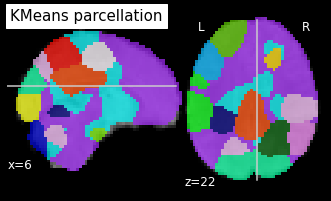

In [ ]:
#plot the k-means clusters on the brain

kmeans_labels_img = kmeans.labels_img_

from nilearn.image import mean_img, index_img

mean_func_img = mean_img(adhd_data.func[0])


display = plotting.plot_roi(kmeans_labels_img, mean_func_img,
                            title="KMeans parcellation",
                            display_mode='xz')

# kmeans_labels_img is a Nifti1Image object, it can be saved to file with
# the following code:
kmeans_labels_img.to_filename('kmeans_parcellation.nii.gz')

In [ ]:
#extract the region signals from kmeans
kmeny = kmeans.transform(adhd_data.func)

In [ ]:
#Measure connectivity using correlation, creating a correlation matrix
correlation_measure_2 = ConnectivityMeasure(kind='correlation', vectorize=True)
correlation_matrices_2 = correlation_measure_2.fit_transform(kmeny)

In [ ]:
np.shape(correlation_matrices_2)

In [ ]:
#creates a correlation matrix that includes both ones that we created, to 
#serve as input to the classifier

X = np.zeros(shape=(40,25,25))

X[:,:20,:20] = correlation_matrices_2

X[:,20:25, 20:25] = DMN_conn



0.0

In [ ]:
np.shape(X)

(40, 25, 25)

In [ ]:
#flattens the lower traingular matrix of the new correlation matrix, creating 
#the feature vector to the neural network below.

#This is my next step

In [ ]:
#creates the labels
labels = adhd_data.phenotypic['adhd']

In [ ]:
#splits training and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3)

In [ ]:
#This code is imported from 'https://towardsdatascience.com/using-neural-networks-for-a-functional-connectivity-classification-of-fmri-data-ff0999057bc6/
#I haven't modified it yet

import keras
import tensorflow.keras.optimizers
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
#from keras.optimizers import Adam
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(32, activation='tanh', kernel_initializer='random_normal', input_shape=a.shape[1:]))
#Second Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Third Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
#Compiling the model
classifier.compile(optimizer = Adam(lr =.0001),loss='binary_crossentropy', metrics =['accuracy'])
#Fitting the model
classifier.fit(np.array(X_train),np.array(y_train), batch_size=32, epochs=100)

In [ ]:
#The above model doesn't work right now because I still haven't finalized the proper feature vector